Dette programmet gjør en stilistisk analyse av strategiene med embeddings (topografisk analyse, se Toubia et al., 2021). Dette er for å sammenlikne og se om noen skiller seg sterkt fra de andre, men er ikke ellers veldig interessant for våre formål. Det er likevel en betydelig (om noe uinteressant) utvidelse av nøkkelordsanalysen.

Også dette programmet tar evigheter å kjøre (først og fremst tar embeddingen lang tid (uten GPU/cuda), og deretter løser vi noen halvtunge optimeringsproblemer (TSP og volumberegninger, se Topography.py)).

In [129]:
from Topography import Topography

import pandas as pd
import os
import gc

In [130]:
folder = "./txt" # change source folder here
chunksize = 500 # change chunksize here


data = []

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)

    if os.path.isfile(file_path):
        # Analysis
        text = Topography(file_path)
        text.embed(chunksize=chunksize)
        embeddings = text.embeddings
        volume = text.volume()
        speed, circuitousness = text.speed()
        data.append([filename[:-4], embeddings, volume, speed, circuitousness])

        del text
        gc.collect() # python's automatic gc is bad

        print(filename) # progress bar

    else:
        msg = "-"*50 + f"\nFound no file with {filename}\n" + "-"*50
        print(msg)
    
df = pd.DataFrame(data, columns=['Country', f'Embeddings ({chunksize})', 'volume', 'speed', 'circuitousness'])
print(df)


China.txt
EU.txt
--------------------------------------------------
Found no file with extras
--------------------------------------------------
Poland.txt
USA.txt
  Country                                   Embeddings (500)    volume  \
0   China  [[-0.09726964, 0.08906725, -0.09776214, -0.488...  2.003385   
1      EU  [[0.030849582, 0.33885244, -1.0729142, 0.29462...  1.922355   
2  Poland  [[-0.15160954, -0.050911434, 0.23864263, 0.168...  1.906332   
3     USA  [[0.2750075, -0.16566397, 0.05493906, 0.205856...  1.938302   

      speed  circuitousness  
0  2.433337        0.062631  
1  2.311660        0.052566  
2  2.360219        0.104344  
3  2.306274        0.030646  


In [ ]:
df.to_pickle("embeddings.pkl") # pickle to avoid stringifying arrays.

TypeError: NDFrame.to_pickle() got an unexpected keyword argument 'index'

In [132]:
# Animations using code from Toppography, potentially usable for presentation.

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import io

def _HDBSCAN_clustering(x_2d):
    """
    Uses HDBSCAN do do unsupervised clustering of the points.
    
    Input is an array of points in 2d.
    Output is a list with the color of each point in 2d.
    """
    from sklearn.cluster import HDBSCAN

    hdbscan = HDBSCAN(min_cluster_size=5, min_samples=5) # Initializing the HDBSCAN model
    clusters = hdbscan.fit_predict(x_2d) # Using HBDSCAN to cluster the points

    # Finding the number of clusters:
    if -1 in clusters:
        num_colors = len(set(clusters)) - 1 # -1 (no cluster) should not be included in the count of clusters
    else:
        num_colors = len(set(clusters))

    colormap = matplotlib.colormaps['gist_rainbow'] # Specifying the colormap
    grey = (0.0, 0.0, 0.0, 1) # Specifying the the color for the points not in a cluster

    norm = mcolors.Normalize(vmin=0, vmax=num_colors) # The cluster indexes must be normalized in order to represent a color

    # Assigning a color to each point based on the cluster indexes
    color_list = []
    for cluster_index in clusters:
        if cluster_index == -1: 
            color_list.append(grey) # The points not in a cluster are black
        else:
            color_list.append(colormap(norm(cluster_index)))
    
    return color_list


def _reduce_dimensions(perplexity, embeddings):
        """
        Helper. Uses t-SNE to reduce the dimensionality of the embeddings.
        Output is an array of points in 2D.
        """

        assert perplexity < len(embeddings), 'The perplexity must be lower than the number of chunks.'

        # Importing and initializing the t-SNE model
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, init="pca", perplexity=perplexity, random_state=42) 

        # Reducing to 2D
        return tsne.fit_transform(embeddings)



def animate(destination, embeddings, perplexity=10):
    """
    Uses t-SNE to visualise the embeddings in 2D.
    Uses HDBSCAN do do unsupervised clustering of the points.
    Makes an animation of the path through the points.

    The resulting gif is saved at the path specified by destination.
    """

    x_2d = _reduce_dimensions(perplexity, embeddings) # t-SNE reduction
    color_list = _HDBSCAN_clustering(x_2d)

    x = x_2d[:, 0]
    y = x_2d[:, 1]
    x_range = np.ptp(x)
    y_range = np.ptp(y)

    axis_set = [min(x) - x_range/20, max(x) + x_range/20, min(y) - y_range/20, max(y) + y_range/20] # Calculating suitable axis
    plt.figure(figsize=(8, 6)) # Fixing the size of the plot
    plt.axis(axis_set) # Fixing the axis of the plot
    plt.title('t-SNE animation') # Setting the title of the plot

    frames = []
    for i, point in enumerate(x_2d):
        plt.scatter(point[0], point[1], label=f"Point {i}", color=color_list[i]) # Plotting the points

        if i > 0:
            x_values = [x[i-1], x[i]]
            y_values = [y[i-1], y[i]]
            plt.plot(x_values, y_values, color='grey', lw=1) # Plotting lines between the points
        
        # Saving frames as images to IO-stream
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(Image.open(buf))

    # Saving frames as GIF
    frames[0].save(destination, save_all=True, append_images=frames[1:], duration=400, loop=0)
    plt.close()

In [133]:
df = pd.read_pickle('embeddings.pkl')
print(df)
for name, embeddings in zip(df['Country'], df['Embeddings (500)']):
    print(name)
    print(len(embeddings))
    animate(f"{name}.gif", embeddings=embeddings, perplexity=5)

  Country                                   Embeddings (500)    volume  \
0   China  [[-0.09726964, 0.08906725, -0.09776214, -0.488...  2.003385   
1      EU  [[0.030849582, 0.33885244, -1.0729142, 0.29462...  1.922355   
2  Poland  [[-0.15160954, -0.050911434, 0.23864263, 0.168...  1.906332   
3     USA  [[0.2750075, -0.16566397, 0.05493906, 0.205856...  1.938302   

      speed  circuitousness  
0  2.433337        0.062631  
1  2.311660        0.052566  
2  2.360219        0.104344  
3  2.306274        0.030646  
China
7
EU
68
Poland
37
USA
40


152


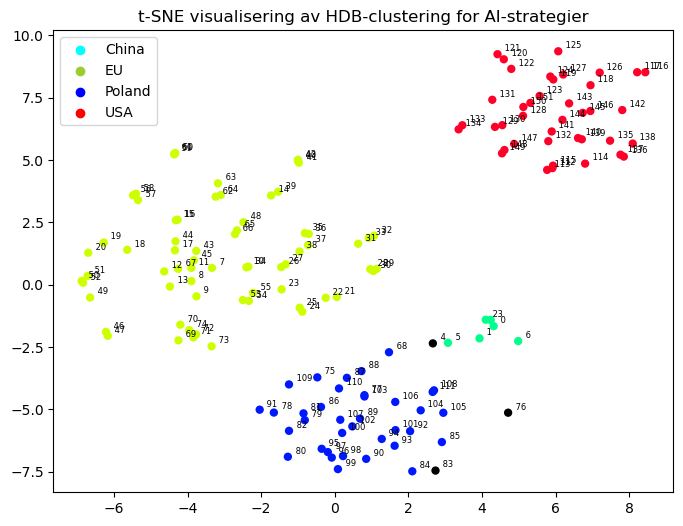

In [147]:
def plot(embeddings, perplexity=10):
    """
    Uses t-SNE to visualise the embeddings in 2D.
    Uses HDBSCAN do do unsupervised clustering of the points.
    Plots the points in different colors according to the clusters.
    """
    x_2d = _reduce_dimensions(perplexity, embeddings) # t-SNE reduction
    color_list = _HDBSCAN_clustering(x_2d)

    offset = np.ptp(x_2d[:, 0])/120 # Calculating an offset to the points to scale the labels properly

    # 2D visualisation with enumerated points
    plt.figure(figsize=(8, 6)) 
    for i, point in enumerate(x_2d):
        plt.scatter(point[0], point[1], color=color_list[i], edgecolor='none') # Plotting the points with colours
        plt.text(point[0] + offset, point[1] + offset, f" {i}", fontsize=6)  # Plotting number labels with offset


df = pd.read_pickle('embeddings.pkl')


longlist = np.vstack(df['Embeddings (500)'])
print(len(longlist))
legend = []
s = 0
for name, embeddings in zip(df['Country'], df['Embeddings (500)']):
    legend.append((name, len(embeddings)))
    s += len(embeddings)


plot(longlist,perplexity=45)

# Brute force legend
plt.scatter([], [], color='cyan', label='China')
plt.scatter([], [], color='yellowgreen', label='EU')
plt.scatter([], [], color='blue', label='Poland')
plt.scatter([], [], color='red', label='USA')

plt.legend()
plt.title("t-SNE visualisering av HDB-clustering for AI-strategier")
plt.show()

In [214]:

df_norm = df.drop(columns=['Embeddings (500)'])
df_num = df_norm.drop(columns=['Country'])
df_norm.iloc[:,1:] = df_num / df_num.max()
df_norm = df_norm.set_index('Country')
df_norm


,volume,speed,circuitousness
Country,,,
China,1.000000,1.000000,0.600236
EU,0.959553,0.949996,0.503780
Poland,0.951555,0.969952,1.000000
USA,0.967513,0.947782,0.293699


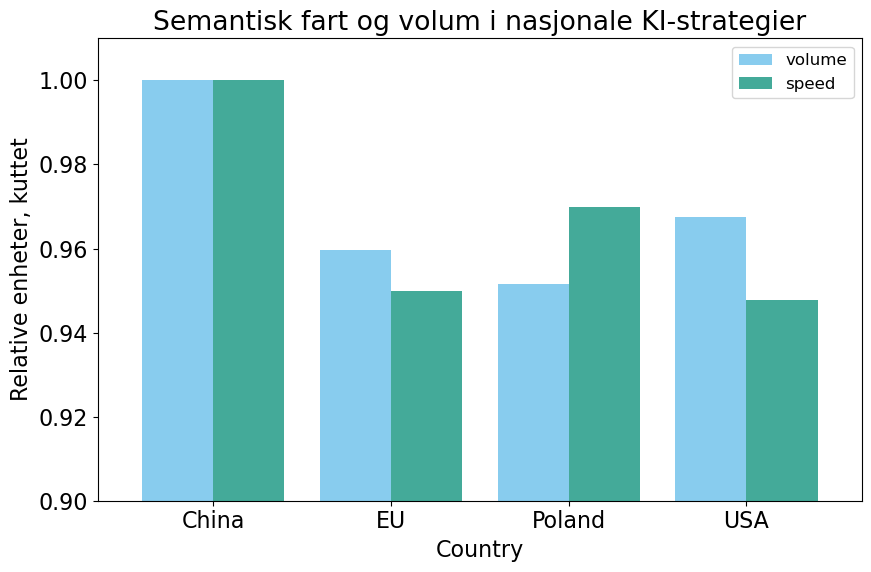

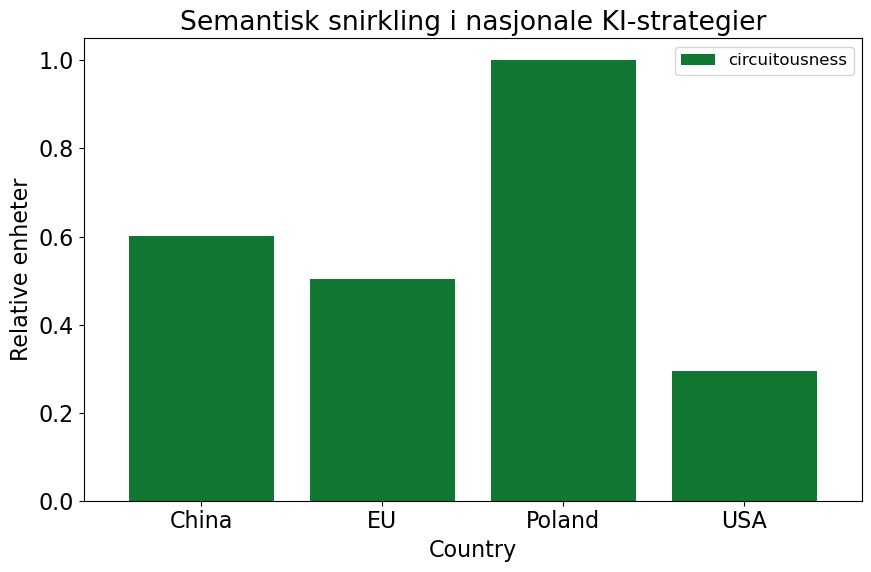

In [215]:
plt.rcParams.update({'font.size': 16})
palette = ['#88CCEE', '#44AA99', '#117733', '#DDCC77', '#CC6677', '#AA4499']

ax = df_norm.drop(columns=['circuitousness']).plot(kind='bar', width=0.8, figsize=(9, 6), color=palette)
plt.ylim(bottom=0.9, top=1.01)
plt.title('Semantisk fart og volum i nasjonale KI-strategier')
plt.ylabel('Relative enheter, kuttet')
plt.xticks(rotation=0)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

ax = df_norm['circuitousness'].plot(kind='bar', width=0.8, figsize=(9, 6), color=palette[2])
plt.title('Semantisk snirkling i nasjonale KI-strategier')
plt.ylabel('Relative enheter')
plt.xticks(rotation=0)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()